In [1]:
library(scupa)
library(Seurat)
library(ggplot2)
library(ggpubr)
library(cowplot)
library(harmony)
library(patchwork)
library(dplyr)
library(scales)
library(reshape2)
library(stringr)
library(tibble)
library(tidydr)
library(rstatix)
library(ggplotify)
library(RColorBrewer)
library(ComplexHeatmap)
options(jupyter.plot_scale=1)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


Loading required package: Rcpp


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Loading required package: grid

ComplexHeatmap version 2.20.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in publi

In [2]:
update_geom_defaults("point", aes(stroke = 0.1))

In [3]:
seu <- schard::h5ad2seurat('data/b16_count_uce_adata.h5ad')
seu <- NormalizeData(seu)

# macro

In [4]:
mac <- readRDS('data/b16_mac.rds')

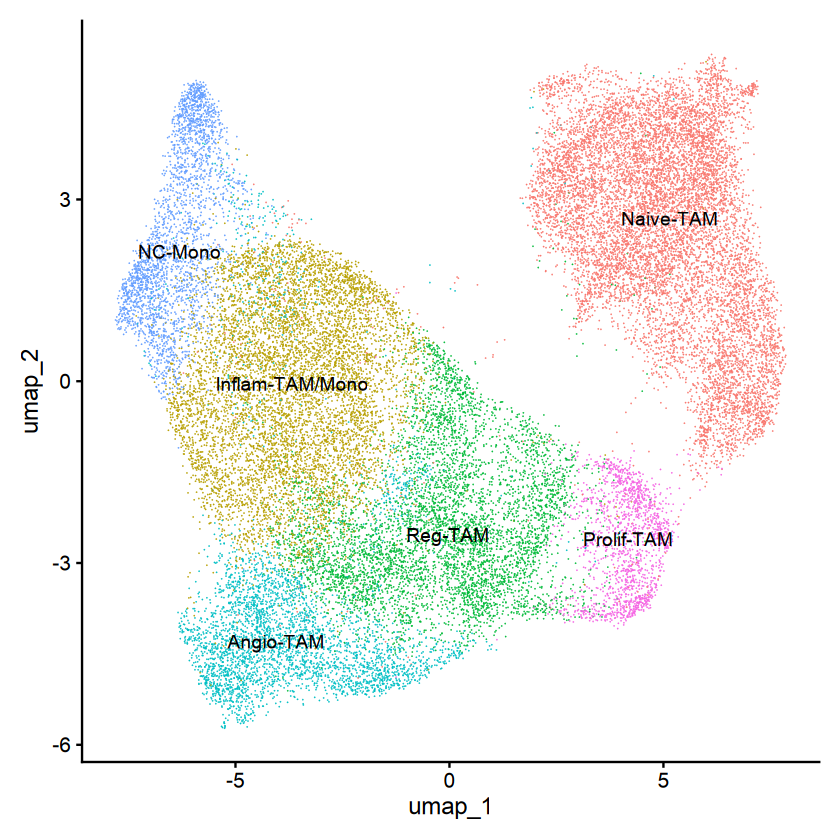

In [5]:
DimPlot(mac, label=T) + NoLegend()

In [6]:
mac_uce <- Embeddings(seu,'Xuce_')[colnames(mac),]
mac[['uce']] <- CreateAssayObject(data=t(mac_uce))

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


In [7]:
mac <- MeasurePolar(mac, celltype='Macro', embedding='uce')

Loaded models and parameters for Macro

Measure polarization state: Mac-a

Measure polarization state: Mac-b

Measure polarization state: Mac-c

Measure polarization state: Mac-d

Measure polarization state: Mac-e



Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


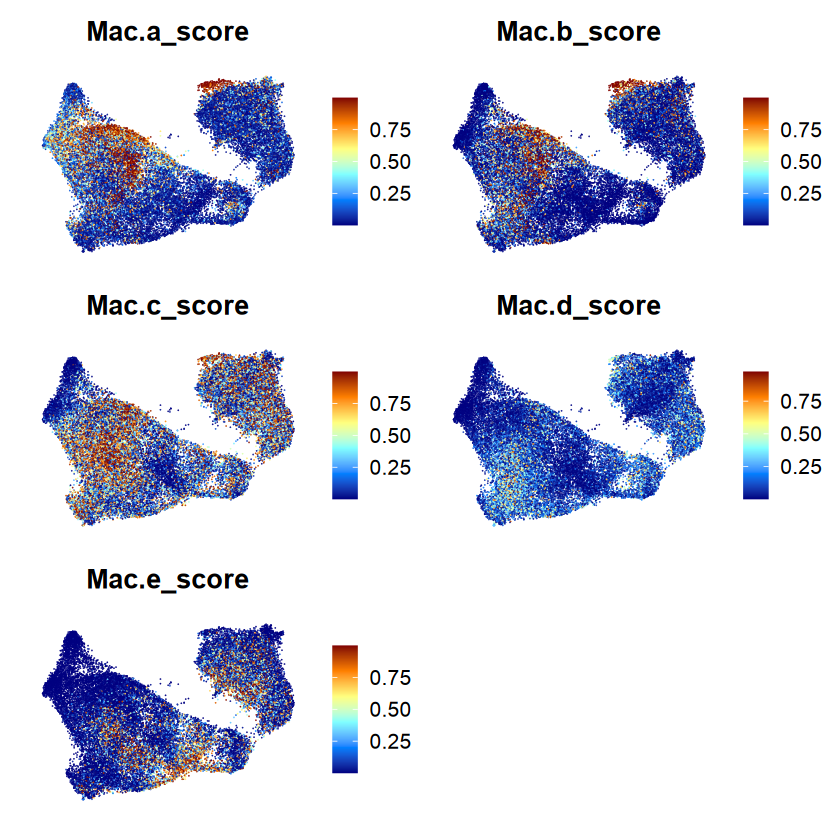

In [8]:
FeaturePlot(mac, c('Mac.a_score','Mac.b_score','Mac.c_score','Mac.d_score','Mac.e_score')) & #
    NoAxes() & scale_color_gradientn(colors=colorRamps::matlab.like(6))

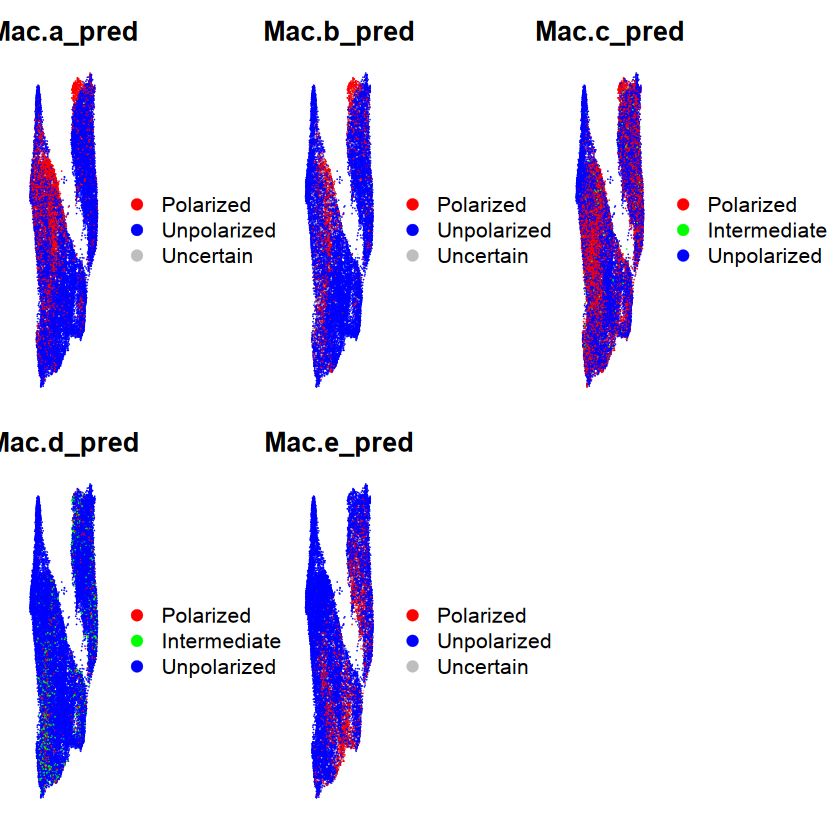

In [9]:
DimPlot(mac, group.by=c('Mac.a_pred','Mac.b_pred','Mac.c_pred','Mac.d_pred','Mac.e_pred')) & #
    NoAxes() & scale_colour_manual(values = c('Polarized'='red','Intermediate'='green','Unpolarized'='blue','Uncertain'='gray'))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


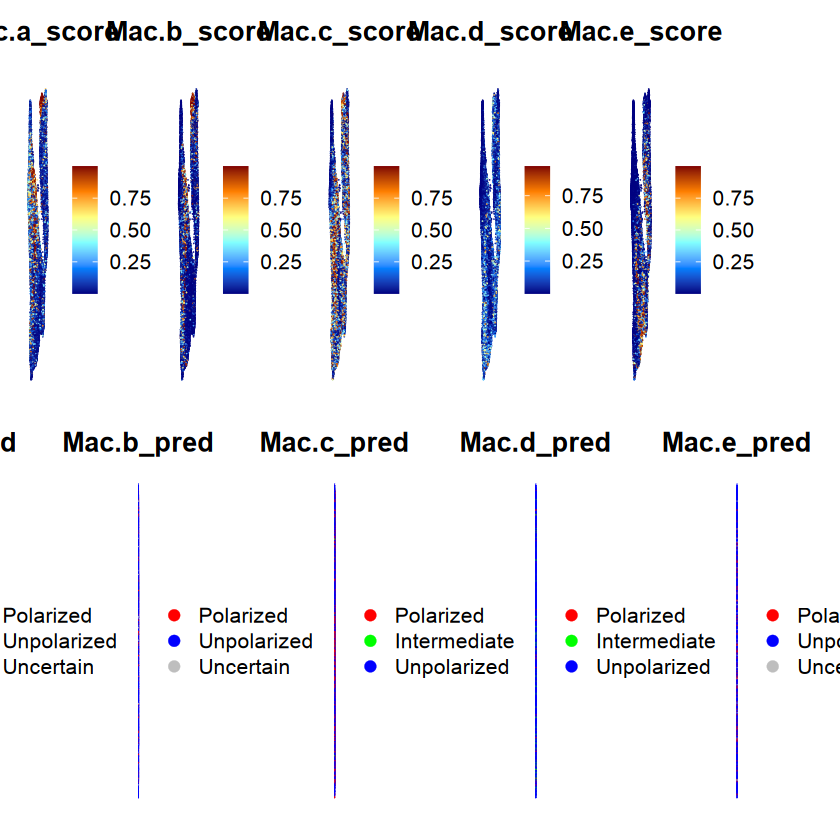

In [10]:
mac_ab_score <- FeaturePlot(mac, c('Mac.a_score','Mac.b_score','Mac.c_score','Mac.d_score','Mac.e_score'), ncol=5) & #
    NoAxes() & scale_color_gradientn(colors=colorRamps::matlab.like(6))
mac_ab_pred <- DimPlot(mac, group.by=c('Mac.a_pred','Mac.b_pred','Mac.c_pred','Mac.d_pred','Mac.e_pred'), ncol=5) & #
    NoAxes() & scale_colour_manual(values = c('Polarized'='red','Intermediate'='green','Unpolarized'='blue','Uncertain'='gray'))
mac_ab_score / mac_ab_pred
ggsave('plot/b16_umap_mac_polar_score_p.pdf', width=15, height=6, device=pdf)
ggsave('plot/b16_umap_mac_polar_score_p.png', width=15, height=6, device=png, dpi=500)

In [11]:
mac_ps <- mac@meta.data %>% 
    select(annotation, treatment, VLP, aCTLA4, orig.ident, Mac.a_pred,Mac.b_pred,Mac.c_pred,Mac.d_pred,Mac.e_pred) %>% 
    melt(id.vars=1:5) %>% group_by( treatment, VLP, aCTLA4, variable) %>% 
    summarise(pct_sig=100*mean(value == 'Polarized'), ncell=n(),ncellsig=sum(value == 'Polarized')) %>%
    mutate(FC=pct_sig/.$pct_sig[1:5], pfisher=1)
for(i in 6:nrow(mac_ps))
{
    ind_control <- ifelse(i %% 5 == 0, 5, i%%5)
    mac_ps$pfisher[i] <- fisher.test(mac_ps[c(ind_control, i),c('ncell','ncellsig')])$p
}
mac_ps <- mac_ps %>% mutate(p.adj=p.adjust(pfisher, method='BH')) %>% add_significance('p.adj',symbols = c("****", "***", "**", "*", ""))
mac_ps_pct <- mac_ps %>%  dcast(variable ~ treatment, value.var='pct_sig') %>% 
    mutate(variable=str_replace(variable,'_pred','')) %>% column_to_rownames('variable')
mac_ps_psig <- mac_ps %>%  dcast(variable ~ treatment, value.var='p.adj.signif') %>% column_to_rownames('variable')

`summarise()` has grouped output by 'treatment', 'VLP', 'aCTLA4'. You can override using the `.groups` argument.


Warning message:
“The input is a data frame-like object, convert it to a matrix.”


pdf 
  2

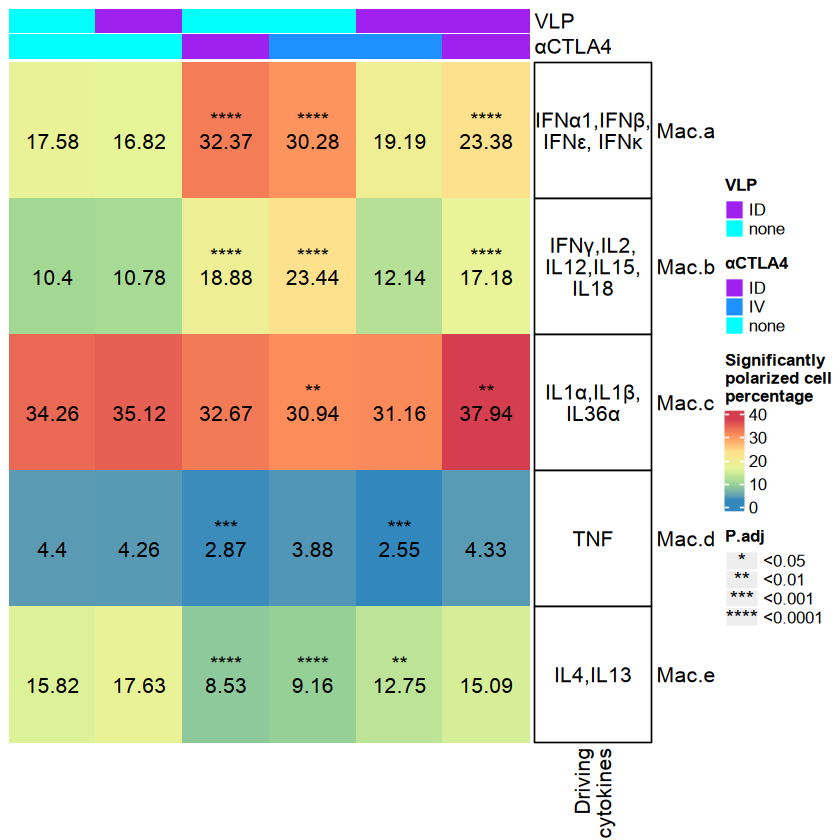

In [12]:
cytkine_drivers <- c('IFNα1,IFNβ,\nIFNε, IFNκ','IFNγ,IL2,\nIL12,IL15,\nIL18','IL1α,IL1β,\nIL36α','TNF','IL4,IL13')
row_ha <- rowAnnotation('Driving\ncytokines'=anno_text(cytkine_drivers,  location = 0.5, just = "center", gp=gpar(border='black'), show_name=T), 
                        width = max_text_width(cytkine_drivers)*1.2) 
col_ha <- HeatmapAnnotation('VLP'= mac_ps %>% select(treatment, VLP, aCTLA4) %>% distinct() %>% pull(VLP),
                           'αCTLA4'= mac_ps %>% select(treatment, VLP, aCTLA4) %>% distinct() %>% pull(aCTLA4),
                           col=list('VLP'=c('none'='cyan','ID'='purple'), 'αCTLA4'=c('none'='cyan','ID'='purple','IV'='dodgerblue')))
ht_mac_ps <- Heatmap(mac_ps_pct, name='Significantly\npolarized cell\npercentage', col = rev(brewer.pal(6,'Spectral')),#colorRamp2(c(0,0.5,1,2,4),c('blue','deepskyblue','white','orange','red')), 
        cluster_rows = F, cluster_columns = F, right_annotation = row_ha, top_annotation = col_ha, show_column_names = F,
       cell_fun = function(j, i, x, y, w, h, col) { grid.text(paste(mac_ps_psig[i, j], round(mac_ps_pct[i,j],2),sep='\n'), x, y) })
lgd_sig <- Legend(title='P.adj', pch = c('*','**','***','****'), type = "points", grid_width = unit(7, "mm"),
                  labels = c('<0.05', '<0.01','<0.001', '<0.0001'))
draw(ht_mac_ps, annotation_legend_list = lgd_sig, legend_grouping = "original", merge_legend = TRUE)
cairo_pdf('plot/b16_heat_mac_polar.pdf', height=4.5, width=6)
draw(ht_mac_ps, annotation_legend_list = lgd_sig, legend_grouping = "original", merge_legend = TRUE)
dev.off()

In [13]:
mac@meta.data %>% 
    select(treatment, orig.ident, Mac.a_score,Mac.b_score,Mac.c_score,Mac.d_score,Mac.e_score) %>% 
    compare_means(Mac.a_score ~ treatment, data=.)

.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Mac.a_score,Control,αCTLA4+VLP ID,1.976320e-52,2.2e-51,<2e-16,****,Wilcoxon
Mac.a_score,Control,αCTLA4 IV,4.123624e-110,6.2e-109,<2e-16,****,Wilcoxon
Mac.a_score,Control,"αCTLA4 IV, VLP ID",1.848176e-21,9.2e-21,<2e-16,****,Wilcoxon
Mac.a_score,Control,αCTLA4 ID,3.112134e-99,4.0e-98,<2e-16,****,Wilcoxon
Mac.a_score,Control,VLP ID,2.712713e-01,5.4e-01,0.271,ns,Wilcoxon
Mac.a_score,αCTLA4+VLP ID,αCTLA4 IV,4.768551e-30,3.8e-29,<2e-16,****,Wilcoxon
Mac.a_score,αCTLA4+VLP ID,"αCTLA4 IV, VLP ID",2.888440e-01,5.4e-01,0.289,ns,Wilcoxon
Mac.a_score,αCTLA4+VLP ID,αCTLA4 ID,2.327513e-32,2.1e-31,<2e-16,****,Wilcoxon
Mac.a_score,αCTLA4+VLP ID,VLP ID,6.441036e-48,6.4e-47,<2e-16,****,Wilcoxon


In [14]:
mac@meta.data %>% 
    select(treatment, orig.ident, Mac.a_score,Mac.b_score,Mac.c_score,Mac.d_score,Mac.e_score) %>% 
    compare_means(Mac.b_score ~ treatment, data=.)

.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Mac.b_score,Control,αCTLA4+VLP ID,2.991189e-52,3.9e-51,< 2e-16,****,Wilcoxon
Mac.b_score,Control,αCTLA4 IV,3.892699e-103,5.8e-102,< 2e-16,****,Wilcoxon
Mac.b_score,Control,"αCTLA4 IV, VLP ID",7.234130e-04,2.2e-03,0.00072,***,Wilcoxon
Mac.b_score,Control,αCTLA4 ID,1.849298e-33,1.7e-32,< 2e-16,****,Wilcoxon
Mac.b_score,Control,VLP ID,7.696432e-02,1.5e-01,0.07696,ns,Wilcoxon
Mac.b_score,αCTLA4+VLP ID,αCTLA4 IV,2.337213e-24,1.9e-23,< 2e-16,****,Wilcoxon
Mac.b_score,αCTLA4+VLP ID,"αCTLA4 IV, VLP ID",1.223540e-12,8.6e-12,1.2e-12,****,Wilcoxon
Mac.b_score,αCTLA4+VLP ID,αCTLA4 ID,1.223351e-01,1.5e-01,0.12234,ns,Wilcoxon
Mac.b_score,αCTLA4+VLP ID,VLP ID,1.133886e-50,1.4e-49,< 2e-16,****,Wilcoxon
